<a href="https://colab.research.google.com/github/CIT-NLP/NLP-final-project/blob/main/LogRegwithSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://drive.google.com/uc?id=1qzdOfeIyjPkDl-RtpVhkaY08h3yizEdn
!gdown https://drive.google.com/uc?id=1fcBqqNnfu_EDbYW5IkiF8FYX5WSQDg3j

Downloading...
From: https://drive.google.com/uc?id=1qzdOfeIyjPkDl-RtpVhkaY08h3yizEdn
To: /content/subset_genre.csv
100% 99.1M/99.1M [00:02<00:00, 48.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fcBqqNnfu_EDbYW5IkiF8FYX5WSQDg3j
To: /content/random_genre.csv
100% 235M/235M [00:03<00:00, 69.7MB/s]


In [3]:
import pandas as pd
from ast import literal_eval

df_random = pd.read_csv("./random_genre.csv")
df_subset = pd.read_csv("./subset_genre.csv")

# interpret cols as lists instead of strings
for col in ['unigrams', 'sentences', 'lem_sent', 'lem_sent_join']: 
  df_random[col] = df_random[col].apply(literal_eval)
  df_subset[col] = df_subset[col].apply(literal_eval)


In [4]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


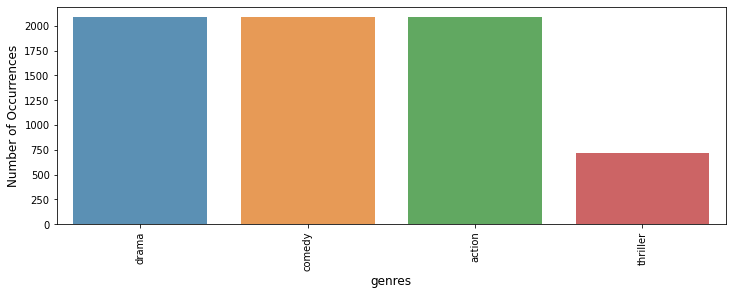

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot subset_dataframe class distribution

cnt_pro = df_subset['genre'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('genres', fontsize=12)
plt.xticks(rotation=90)
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


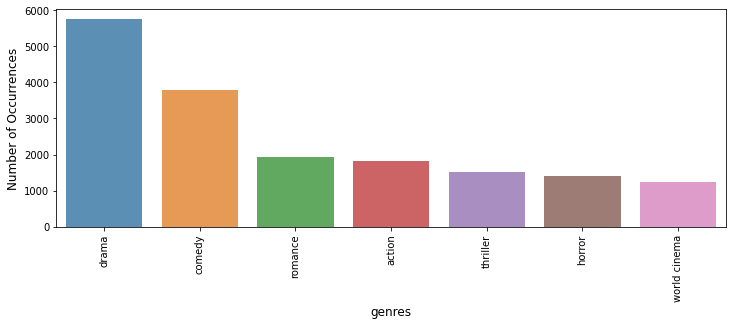

In [7]:
# Plot random_dataframe class distribution

cnt_pro = df_random['genre'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('genres', fontsize=12)
plt.xticks(rotation=90)
plt.show();

# Random Dataframe

In [8]:
from sklearn.model_selection import train_test_split
import gensim
from gensim.models.doc2vec import TaggedDocument

train, test = train_test_split(df_random, test_size=0.2, random_state=42)

train_tagged = train.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)


In [9]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

2

In [10]:
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 13939/13939 [00:00<00:00, 1977286.37it/s]


In [11]:
from sklearn import utils

for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 13939/13939 [00:00<00:00, 3260157.44it/s]


In [12]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [13]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [14]:
import numpy as np

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

## Without SMOTE

In [15]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_resample(X_train, y_train)

print(X_train.shape)

print(os_smote_X.shape)

(13939, 100)
(32158, 100)


In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [17]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.47403156384505024
Testing F1 score: 0.44166687626967704


## With SMOTE

In [18]:
from sklearn.metrics import accuracy_score, f1_score

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(os_smote_X, os_smote_Y)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# Subset Dataframe

In [20]:
train, test = train_test_split(df_subset, test_size=0.2, random_state=42)

train_tagged = train.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r['unigrams'], tags=r.genre), axis=1)


In [21]:
model_dbow = Doc2Vec(dm=0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 5582/5582 [00:00<00:00, 448637.66it/s]


In [22]:
for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 5582/5582 [00:00<00:00, 3168575.58it/s]


In [23]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [24]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

## Without SMOTE

In [27]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6375358166189111
Testing F1 score: 0.6336873145332803


## With SMOTE

In [28]:
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_resample(X_train, y_train)

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(os_smote_X, os_smote_Y)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


Testing accuracy 0.6446991404011462
Testing F1 score: 0.6451616493374299
